

# Compute envelope correlations in source space (NIH data)


Compute envelope correlations of orthogonalized activity in source
space using resting state CTF data.


In [ ]:
%matplotlib qt

In [ ]:
# https://docs.enthought.com/mayavi/mayavi/tips.html
from mayavi.mlab import options, init_notebook
options.offscreen = True
init_notebook('png')

In [ ]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.connectivity import envelope_correlation
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs
from mne.preprocessing import compute_proj_ecg, compute_proj_eog

data_path = '.'
subjects_dir = op.join(data_path, 'subjects')
subject = 'DLRMCDEH'
raw_fname = op.join(data_path, 'DLRMCDEH_rest_20180917_01.ds')

Here we do some things in the name of speed, such as crop (which will
hurt SNR) and downsample. Then we compute SSP projectors and apply them.



In [ ]:
raw = mne.io.read_raw_ctf(raw_fname)
raw.load_data().pick_types(meg=True, eeg=False).resample(80)

In [ ]:
projs_ecg, _ = compute_proj_ecg(raw, n_grad=1, n_mag=2)

In [ ]:
projs_eog, _ = compute_proj_eog(raw, n_grad=1, n_mag=2, ch_name='MLT31-1609')

In [ ]:
raw.info['projs'] += projs_ecg
raw.info['projs'] += projs_eog

In [ ]:
raw.apply_proj()
cov = mne.compute_raw_covariance(raw)  # compute before band-pass of interest

Now we band-pass filter our data and create epochs.



In [ ]:
raw.filter(14, 30)
events = mne.make_fixed_length_events(raw, duration=5.)
epochs = mne.Epochs(raw, events=events, tmin=0, tmax=5.,
                    baseline=None, reject=dict(mag=8e-13), preload=True)
del raw

In [ ]:
epochs_fname = '%s_rest-epo.fif' % subject
# epochs.save(epochs_fname)
assert op.isfile(epochs_fname)

Compute the forward and inverse
-------------------------------



In [ ]:
fname_trans = '%s-trans.fif' % subject
fname_src = op.join(subjects_dir, subject, 'bem', subject + '-oct-6-src.fif')
fname_bem = op.join(subjects_dir, subject, 'bem', subject + '-bem-sol.fif')
fwd = mne.make_forward_solution(epochs.info, fname_trans, fname_src, fname_bem)
inv = make_inverse_operator(epochs.info, fwd, cov)
fname_inv = '%s_rest-inv.fif' % subject

In [ ]:
mne.minimum_norm.write_inverse_operator(fname_inv, inv)
inv = mne.minimum_norm.read_inverse_operator(fname_inv)

Compute label time series and do envelope correlation
-----------------------------------------------------



In [ ]:
# !SUBJECTS_DIR=$PWD/subjects python -c "import mne; mne.datasets.fetch_fsaverage(verbose=True)"
# mne.datasets.fetch_aparc_sub_parcellation(verbose=True)
# labels = mne.read_labels_from_annot('fsaverage', 'aparc_sub',
#                                     subjects_dir=subjects_dir)
# labels = mne.morph_labels(labels, subject,
#                           subjects_dir=subjects_dir, verbose=True)
# mne.write_labels_to_annot(labels, subject, 'aparc_sub',
#                           subjects_dir=subjects_dir)

In [15]:
labels = mne.read_labels_from_annot(subject, 'aparc_sub',
                                    subjects_dir=subjects_dir)
epochs.apply_hilbert()  # faster to apply in sensor space
stcs = apply_inverse_epochs(epochs, inv, lambda2=1. / 9., pick_ori='normal',
                            return_generator=True)
label_ts = mne.extract_label_time_course(
    stcs, labels, inv['src'], return_generator=True)

In [16]:
corr = envelope_correlation(label_ts, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 4)
    Created the whitener using a noise covariance matrix with rank 268 (4 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 272 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 2 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 3 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 4 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 5 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 6 / 30
Extracting time courses for 450 labels (mode: mean_flip)
Processing epoch : 7 / 30
Extracting time courses f

In [17]:
# let's plot this matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
fig.tight_layout()

Compute the degree and plot it
------------------------------




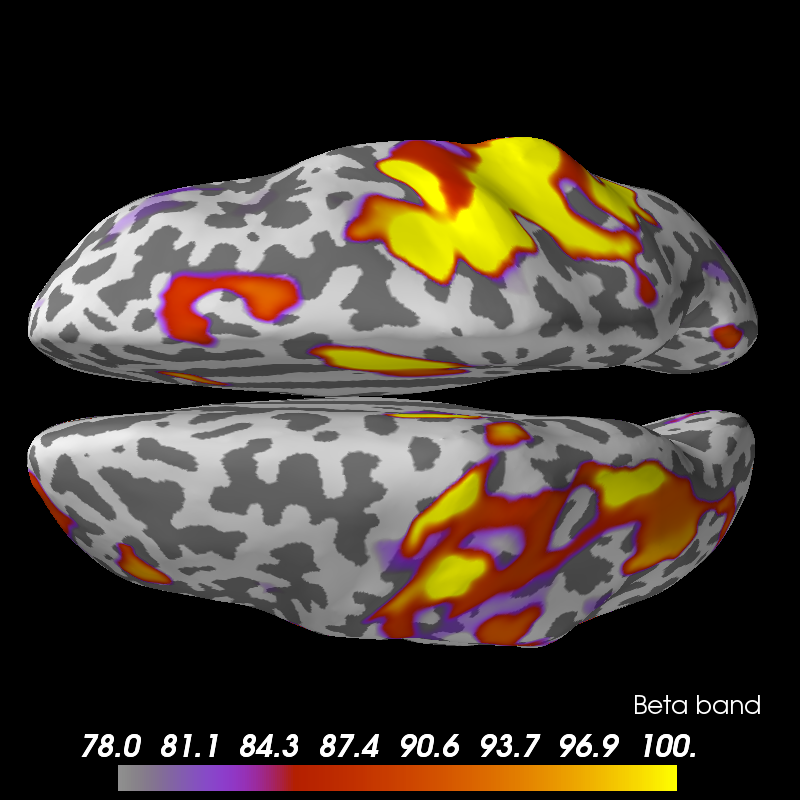

In [18]:
threshold_prop = 0.15  # percentage of strongest edges to keep in the graph
degree = mne.connectivity.degree(corr, threshold_prop=threshold_prop)
stc = mne.labels_to_stc(labels, degree)
stc = stc.in_label(mne.Label(inv['src'][0]['vertno'], hemi='lh') +
                   mne.Label(inv['src'][1]['vertno'], hemi='rh'))
brain = stc.plot(
    clim=dict(kind='percent', lims=[75, 85, 95]), colormap='gnuplot',
    subjects_dir=subjects_dir, views='dorsal', hemi='both',
    smoothing_steps=25, time_label='Beta band')
brain  # Need to be on latest PySurfer `master` for this to display: